# 0. Importing Libaries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import datetime

### Setting up GPU

In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.1.0+cu121
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver**********
CUDNN version: 8801

Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Sep__8_19:56:38_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.52
Build cuda_12.3.r12.3/compiler.33281558_0
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
device = torch.device('cuda:0')
device 

device(type='cuda', index=0)

In [4]:
# device = torch.device('cpu')
# device

# 1. Importing and Preparing Dataset

### Downloading nltk dataset

In [5]:
import nltk
nltk.download('reuters')
nltk.download('punkt')
nltk.download('abc')

[nltk_data] Downloading package reuters to C:\Users\minnb\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\minnb\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package abc to C:\Users\minnb\nltk_data...
[nltk_data]   Package abc is already up-to-date!


True

### Import Australian Broadcasting Corporation (ABC) news for training

In [6]:
from nltk.corpus import abc
abc.words()

['PM', 'denies', 'knowledge', 'of', 'AWB', 'kickbacks', ...]

In [7]:
# .sents() returns sentences already tokenized
corpus = abc.sents()
len(corpus)

29059

In [8]:
len(corpus[5])

27

In [9]:
# Limiting the corpus to only 5000 documents since using the entire corpus
# is not feasible with available computational resources
corpus = corpus[0:5000]

In [10]:
len(corpus)

5000

In [11]:
# Convert all characters to lowercase to handle case sensitivity
corpus = [[word.lower() for word in sent] for sent in corpus]

In [12]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [13]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [14]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9774


In [15]:
#append UNK
vocab.append('<UNK>')

In [16]:
word2index['<UNK>'] = voc_size # since current word2index[0:voc_size-1]

In [17]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

In [18]:
#vocab size
voc_size = len(vocab)
print(voc_size)

9775


In [48]:
#check token count
wc = 0
for i in range(len(corpus)):
    wc += len(corpus[i])
wc

134349

# 2. Preparing training data

### Check corpus (sentences)

In [19]:
i = 0
for c in corpus:
    print(c)
    # Stop after 3
    i+=1
    if i > 2:
        break

['pm', 'denies', 'knowledge', 'of', 'awb', 'kickbacks', 'the', 'prime', 'minister', 'has', 'denied', 'he', 'knew', 'awb', 'was', 'paying', 'kickbacks', 'to', 'iraq', 'despite', 'writing', 'to', 'the', 'wheat', 'exporter', 'asking', 'to', 'be', 'kept', 'fully', 'informed', 'on', 'iraq', 'wheat', 'sales', '.']
['letters', 'from', 'john', 'howard', 'and', 'deputy', 'prime', 'minister', 'mark', 'vaile', 'to', 'awb', 'have', 'been', 'released', 'by', 'the', 'cole', 'inquiry', 'into', 'the', 'oil', 'for', 'food', 'program', '.']
['in', 'one', 'of', 'the', 'letters', 'mr', 'howard', 'asks', 'awb', 'managing', 'director', 'andrew', 'lindberg', 'to', 'remain', 'in', 'close', 'contact', 'with', 'the', 'government', 'on', 'iraq', 'wheat', 'sales', '.']


In [20]:
# Batching function
def random_batch(batch_size, word_sequence):
    
    # Make skip gram of two size window
    skip_grams = []
    # loop each word sequence
    # we starts from 2 because 0 has no context (window size = 2)
    # we stop at third last for the same reason
    for sent in word_sequence:
        for i in range(2, len(sent) - 2):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 2]], word2index[sent[i - 1]],
                       word2index[sent[i + 1]], word2index[sent[i + 2]]]
            for w in context:
                skip_grams.append([target, w])
    
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels)

In [21]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[6471]
 [6775]]
Target:  [[1363]
 [7417]]


# 3. Model

In [22]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs = all_vocabs.to(device) # send vocabs to GPU
all_vocabs.shape

torch.Size([2, 9775])

In [23]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)
    
    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]
        
        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)    
            
        return nll # negative log likelihood
    
    def get_vector(self, word):
        id_tensor = torch.LongTensor([word2index[word]])
        id_tensor = id_tensor
        v_embed = self.embedding_v(id_tensor)
        u_embed = self.embedding_u(id_tensor) 
        word_embed = (v_embed + u_embed) / 2 
        # x, y = word_embed[0][0].item(), word_embed[0][1].item()

        return word_embed

# 4. Training

In [40]:
batch_size     = 2 # mini-batch size
embedding_size = 50 #  according to word2vec paper 50-300
model          = Skipgram(voc_size, embedding_size)
model = model.to(device) # send model to GPU


optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time, elapsed_mins, elapsed_secs

In [42]:
import time

# Training
# Since our training data is small, 1000 epochs instead of between 3 and 50 as per the paper
num_epochs = 1000
total_time = 0 # Store total training time
losses = [] # Store losses over training
start = time.time()
for epoch in range(num_epochs):
    
    
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    optimizer.zero_grad()
    
    loss = model(input_batch, target_batch, all_vocabs)
    losses.append(loss)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        end = time.time()
        total, epoch_mins, epoch_secs = epoch_time(start, end)
        total_time += total
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        start = time.time()


Epoch: 100 | cost: 24.066109 | time: 0m 32s
Epoch: 200 | cost: 29.042301 | time: 0m 32s
Epoch: 300 | cost: 30.428570 | time: 0m 31s
Epoch: 400 | cost: 18.916611 | time: 0m 31s
Epoch: 500 | cost: 27.315498 | time: 0m 31s
Epoch: 600 | cost: 30.305450 | time: 0m 31s
Epoch: 700 | cost: 28.257732 | time: 0m 31s
Epoch: 800 | cost: 29.975349 | time: 0m 31s
Epoch: 900 | cost: 15.977736 | time: 0m 31s
Epoch: 1000 | cost: 22.481169 | time: 0m 31s


In [43]:
print(f'Training Loss: {loss}, Training Time: {str(datetime.timedelta(seconds=total_time))}')

Training Loss: 22.481168746948242, Training Time: 0:05:15.885102


In [44]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/Skipgram-v1.pt')

In [45]:
Data = {
    'corpus': corpus,
    'vocab': vocab,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': embedding_size
}

In [46]:
pickle.dump(Data,open('./app/models/Data.pkl', 'wb'))

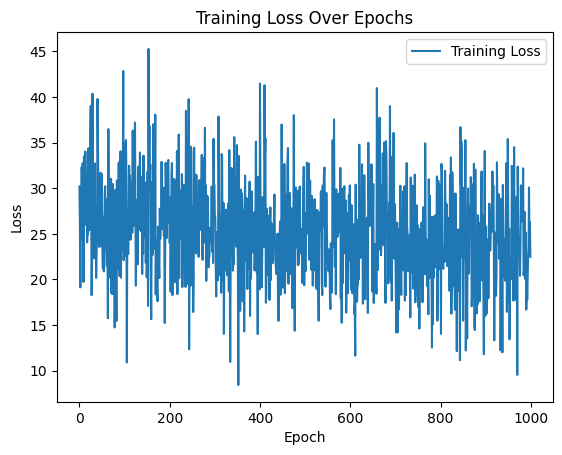

In [47]:
# Extract the numerical values from the tensors
loss_values = [loss.item() for loss in losses]

# Plot the losses
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()